In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms


import numpy as np
import matplotlib.pyplot as plt


import time

### Dataset Loading and Transformation

In [2]:


# Transforms defined for the train, validation, and test datasets
train_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor()])

val_transform = transforms.Compose([transforms.Resize((256,256)),
                                   transforms.ToTensor()])


In [3]:
dir = '../Label_Data_TrainTest/'
train_dir, val_dir = dir+'train', dir+'val'
batch_size = 32
num_workers = 2

# Datasets extracted from their respective directories and some transformation applied to them
train_set = datasets.ImageFolder(train_dir, transform = train_transform)
val_set = datasets.ImageFolder(val_dir, transform = val_transform)



# Datasets loaded onto iterable object in form of batches 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True, num_workers=num_workers)



### Save trained model

In [4]:
# Loading the state dict into our model
state_dict = torch.load('resnet152_4000Iterations.pth', map_location='cuda:0')

from torchvision import models
model = models.resnet152(pretrained=True)

features= model.fc.in_features
model.fc = nn.Linear(features, len(train_set.classes))

model.load_state_dict(state_dict)



<All keys matched successfully>

### Performance of finetuned network on test dataset


Total number of correct predictions in batch number 1: 30/32
Correct Label: ['Prada', 'Other']


Total number of correct predictions in batch number 2: 32/32
Correct Label: []


Total number of correct predictions in batch number 3: 30/32
Correct Label: ['Dior', 'Gucci']


Total number of correct predictions in batch number 4: 29/32
Correct Label: ['Other', 'Giorgio Armani', 'Giorgio Armani']


Total number of correct predictions in batch number 5: 31/32
Correct Label: ['Ralph Lauren']


Total number of correct predictions in batch number 6: 31/32
Correct Label: ['Hermes']


Total number of correct predictions in batch number 7: 30/32
Correct Label: ['Ralph Lauren', 'Versace']


Total number of correct predictions in batch number 8: 30/32
Correct Label: ['Gucci', 'Versace']


Total number of correct predictions in batch number 9: 30/32
Correct Label: ['Chanel', 'Chanel']


Total number of correct predictions in batch number 10: 31/32
Correct Label: ['Versace']


Total number of correc

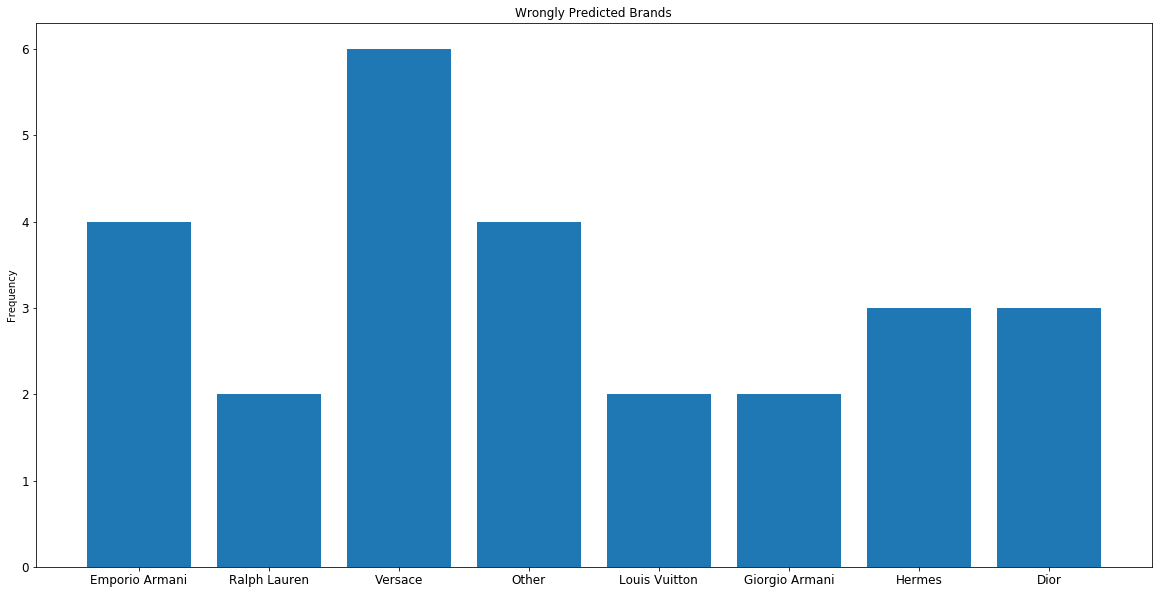

In [6]:
# Checking out the Prediction on the validation set
device = torch.device('cuda')
model.to(device)

model.eval()
with torch.no_grad():
    correct  = 0
    total = 0
    val_batch=0
    
    wrong_total = []
    
    for images_val, labels_val in val_loader:
        
        val_batch +=1
        
        images_val, labels_val = images_val.to(device), labels_val.to(device)
        outputs = model(images_val)
        _,predicted = torch.max(outputs, 1)
        
        total += labels_val.size(0)
        correct += (predicted == labels_val).sum().item()
        
        
        # Check how many correct predictions are made in each each batch of the validation dataset
        print('\nTotal number of correct predictions in batch number {}: {}/{}'.format(val_batch, (predicted == labels_val).sum().item(), len(images_val)))
        
        # Implementation to extract the wrongly predicted classes
        bool = (labels_val == predicted)
        index = [ind for ind, val in enumerate(bool) if not val]
        correct_val = labels_val[index]
        wrong_val = predicted[index]
        wrong_labels = [val_set.classes[x] for x in wrong_val]
        correct_labels = [val_set.classes[x] for x in correct_val]
        print('Correct Label:', correct_labels)
#         print('Wrongly Predicted Labels:', wrong_labels)
        wrong_total.append(wrong_labels)
        
        
        print('='*100,'\n')
    
    print('Accuracy: {:.2f}%'.format(correct/total*100))
    
    # Flatten the list wrong_total
    wrong_total =[item for sublist in wrong_total for item in sublist]
    
    import collections
    
    BarData = collections.Counter(wrong_total)
    wrong_brands = BarData.keys()
    freq = BarData.values()
    
    plt.figure(figsize = (20,10))
    plt.bar(wrong_brands, freq)
    plt.title('Wrongly Predicted Brands')
    plt.ylabel('Frequency')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)